In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py'>

In [3]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_output/"
output_path = input_path

figure_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_results/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_annotation/"

In [4]:
def get_pos_control_correlation(input_dataframe, pos_ctrl_string, input_features):
    
    pos_ctrl_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == pos_ctrl_string]

    corr_pos_ctrl = None

    if (len(pos_ctrl_dataframe) == 2 ):

        well_1_features = pos_ctrl_dataframe.iloc[0][input_features].values
        well_2_features = pos_ctrl_dataframe.iloc[1][input_features].values
    
        corr = np.corrcoef(well_1_features.astype(float), well_2_features.astype(float))
        np.fill_diagonal(corr, np.nan)

        corr_pos_ctrl = np.nanmedian(corr)

    return corr_pos_ctrl

In [5]:
def get_median_pos_ctrl_correlation(input_dataframe, input_features):

    tetrandrine_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == 'Tetrandrine']
    tetrandrine_median_features = tetrandrine_dataframe[input_features].median(axis=0)

    nocodazole_dataframe = input_dataframe.loc[input_dataframe['Metadata_RoughID'] == 'Nocodazole']
    nocodazole_median_features = nocodazole_dataframe[input_features].median(axis=0)
    
    corr = np.corrcoef(tetrandrine_median_features.astype(float), nocodazole_median_features.astype(float))
    np.fill_diagonal(corr, np.nan)

    return np.nanmedian(corr)

In [6]:
def pad_numbers(value):
    match = re.match(r"([A-Z])(\d+)", value)
    if match:
        letter = match.group(1)
        number = match.group(2).zfill(2)  # Pad number to 2 digits
        return f"{letter}{number}"
    return value

In [7]:
# get folder list 
# load for each site the normalized files
# reduce the features selecting the correct feature list
folders = [name for name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, name))]

In [8]:
dataframes_normalized_reduced_dict = {}

for folder in folders:

    site_specific_path = os.path.join(input_path, folder)

    # loads mad_robustize normalized data
    pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize_reduced-corr.csv"
    file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

    for file in file_list:
    
        plate_map_name = os.path.splitext(os.path.basename(file))[0]
    
        try:
        
            dataframe = pd.read_csv(file)
            row_count = dataframe.shape[0]
        
            print(f"INFO: {plate_map_name} has {row_count} rows")

            dict_key = dataframe['Metadata_staining_date'][0].astype(str) + "_" + dataframe['Metadata_source'][0] + "_" + dataframe['Metadata_plate_map_name'][0]

            dataframes_normalized_reduced_dict[dict_key] = dataframe
        
        except Exception as e:
        
            print(f"Error reading file {plate_map_name}: {e}") 

INFO: B1007_R3_mad_robustize_reduced-corr has 381 rows
INFO: B1002_R1_mad_robustize_reduced-corr has 382 rows
INFO: B1002_R2_mad_robustize_reduced-corr has 384 rows
INFO: B1003_R4_mad_robustize_reduced-corr has 384 rows
INFO: B1002_R3_mad_robustize_reduced-corr has 382 rows
INFO: B1004_R1_mad_robustize_reduced-corr has 379 rows
INFO: B1003_R2_mad_robustize_reduced-corr has 383 rows
INFO: B1003_R3_mad_robustize_reduced-corr has 382 rows
INFO: B1006_R3_mad_robustize_reduced-corr has 381 rows
INFO: B1002_R4_mad_robustize_reduced-corr has 383 rows
INFO: B1001_R2_mad_robustize_reduced-corr has 379 rows
INFO: B1004_R3_mad_robustize_reduced-corr has 381 rows
INFO: B1001_R4_mad_robustize_reduced-corr has 383 rows
INFO: B1004_R4_mad_robustize_reduced-corr has 378 rows
INFO: B1004_R2_mad_robustize_reduced-corr has 380 rows
INFO: B1007_R2_mad_robustize_reduced-corr has 381 rows
INFO: B1007_R1_mad_robustize_reduced-corr has 380 rows
INFO: B1001_R1_mad_robustize_reduced-corr has 378 rows
INFO: B100

In [9]:
imaging_date = []
staining_date = []
plate_name = []
replicate_number = []
plate_map_name = []
plate_code_list = []
user = []
source = []
picklist_name = []
noco_corr = []
tet_corr = []
pos_ctrl_corr = []

for plate_code in dataframes_normalized_reduced_dict:

    print(f"Testing {plate_code}")
    
    dataframe_for_QC1 = dataframes_normalized_reduced_dict[plate_code]
    
    print(f"Original layout is {dataframe_for_QC1['Metadata_replicate_number'][0]}")
    
    features = CBE.get_feature_vector(dataframe_for_QC1)
    metadata_dataframe = set(dataframe_for_QC1.columns) - set(features)
    
    ### convert sets to list
    features_list = list(features)
    metadata_list = list(metadata_dataframe)
    
    imaging_date.append(dataframe_for_QC1['Metadata_imaging_date'][0])
    staining_date.append(dataframe_for_QC1['Metadata_staining_date'][0])
    plate_name.append(dataframe_for_QC1['Metadata_plate_name'][0])
    replicate_number.append(dataframe_for_QC1['Metadata_replicate_number'][0])
    plate_map_name.append(dataframe_for_QC1['Metadata_plate_map_name'][0])
    plate_code_list.append(plate_code)
    user.append(dataframe_for_QC1['Metadata_user'][0])
    source.append(dataframe_for_QC1['Metadata_source'][0])
    picklist_name.append(dataframe_for_QC1['Metadata_picklist_name'][0])
    noco_corr.append(get_pos_control_correlation(dataframe_for_QC1, 'Nocodazole', features_list))
    tet_corr.append(get_pos_control_correlation(dataframe_for_QC1, 'Tetrandrine', features_list))
    pos_ctrl_corr.append(get_median_pos_ctrl_correlation(dataframe_for_QC1, features_list))

quality_control_1 = {
    'Metadata_imaging_date': imaging_date,
    'Metadata_staining_date': staining_date,
    'Metadata_plate_name': plate_name,
    'Metadata_replicate_number': replicate_number,
    'Metadata_plate_map_name': plate_map_name,
    'Metadata_plate_code': plate_code_list,
    'Metadata_user': user,
    'Metadata_source':source,
    'Metadata_noco_corr': noco_corr,
    'Metadata_tet_corr': tet_corr,
    'Metadata_pos_ctrl_corr': pos_ctrl_corr
}

Testing 230717_IMTM_B1007_R3
Original layout is R3
Testing 230707_IMTM_B1002_R1
Original layout is R1
Testing 230707_IMTM_B1002_R2
Original layout is R2
Testing 230718_IMTM_B1003_R4
Original layout is R4
Testing 230709_IMTM_B1002_R3
Original layout is R3
Testing 230711_IMTM_B1004_R1
Original layout is R1
Testing 230710_IMTM_B1003_R2
Original layout is R2
Testing 230720_IMTM_B1003_R3
Original layout is R3
Testing 230714_IMTM_B1006_R3
Original layout is R3
Testing 230709_IMTM_B1002_R4
Original layout is R4
Testing 230706_IMTM_B1001_R2
Original layout is R2
Testing 230719_IMTM_B1004_R3
Original layout is R3
Testing 230707_IMTM_B1001_R4
Original layout is R4
Testing 230712_IMTM_B1004_R4
Original layout is R4
Testing 230711_IMTM_B1004_R2
Original layout is R2
Testing 230716_IMTM_B1007_R2
Original layout is R2
Testing 230716_IMTM_B1007_R1
Original layout is R1
Testing 230706_IMTM_B1001_R1
Original layout is R1
Testing 230713_IMTM_B1005_R4
Original layout is R4
Testing 230713_IMTM_B1006_R1
Or

In [10]:
quality_control_1_df = pd.DataFrame(quality_control_1)

In [11]:
quality_control_1_df = pd.DataFrame(quality_control_1) 

file_path_quality_control_1 = os.path.join(output_path, 'quality_control_1.csv')
quality_control_1_df .to_csv(file_path_quality_control_1, index=False)

In [12]:
quality_control_1_melt = pd.melt(quality_control_1_df, 
        id_vars = ["Metadata_imaging_date",
                   "Metadata_staining_date",
                   "Metadata_plate_name",
                   "Metadata_replicate_number",
                   "Metadata_plate_map_name",
                   "Metadata_plate_code",
                   "Metadata_user",
                   "Metadata_source"],
        value_vars = ["Metadata_noco_corr", 
                      "Metadata_tet_corr", 
                      "Metadata_pos_ctrl_corr"],
        var_name="Tested pair",
        value_name="Correlation")

In [13]:
# TODO: Update visualizations
# TODO: Order plates by imaging time
def intra_plate_qc(input_dataframe, site_name, path):

    quality_control_1 = input_dataframe.loc[input_dataframe['Metadata_source'] == site_name]

    # Cell Number output for FMP
    figure_path = os.path.join(path + os.sep + site_name)  

    try:
        os.mkdir(figure_path)

    except OSError as error:

        print("Error: directory cannot be created") 


    imaging_date_list = quality_control_1["Metadata_staining_date"].unique()
    imaging_date_list.sort()

    for date in imaging_date_list:
    
        qc = quality_control_1.loc[quality_control_1["Metadata_staining_date"] == date]
    
        qc = qc.replace(to_replace="Metadata_noco_corr", value="Nocodazole wells")
        qc = qc.replace(to_replace="Metadata_tet_corr", value="Tetrandrine wells")
        qc = qc.replace(to_replace="Metadata_pos_ctrl_corr", value="Median positive controls")
    
        plt.figure(figsize=(14, 7))
    
        sns.catplot(qc,
                    kind="bar",
                    x="Metadata_plate_map_name",
                    y="Correlation",
                    hue="Tested pair",
                    height=6,
                    aspect=1)
    
        plt.title(date, loc = 'left',fontsize= 16)
        plt.xlabel('Plate Map Name')
        plt.ylabel('Correlation')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
    
        plt.savefig(figure_path + os.sep + str(date) + '_' + site_name + '_IntraPlate.pdf', format='pdf', bbox_inches = "tight")

Error: directory cannot be created


<ipython-input-13-4e26db73eec3>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 7))


<Figure size 1008x504 with 0 Axes>

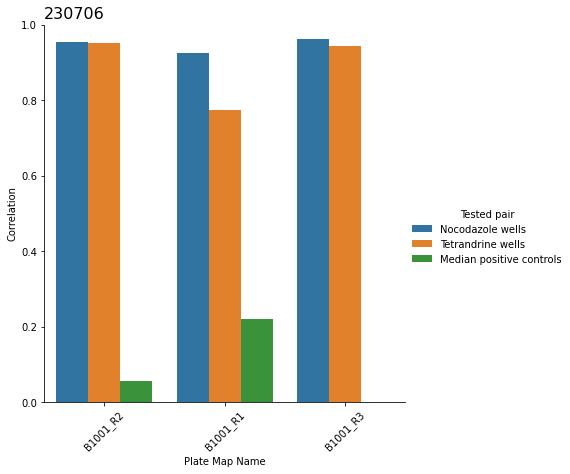

<Figure size 1008x504 with 0 Axes>

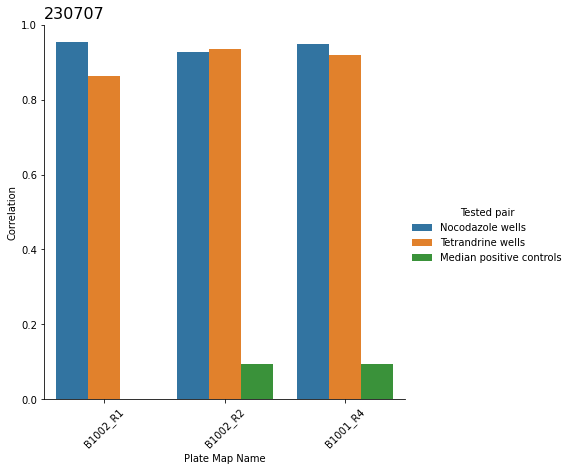

<Figure size 1008x504 with 0 Axes>

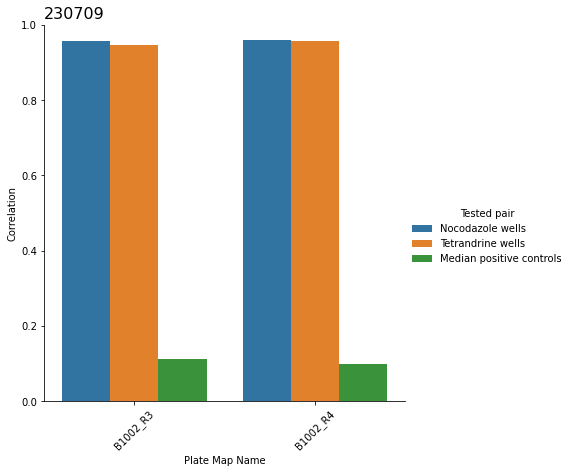

<Figure size 1008x504 with 0 Axes>

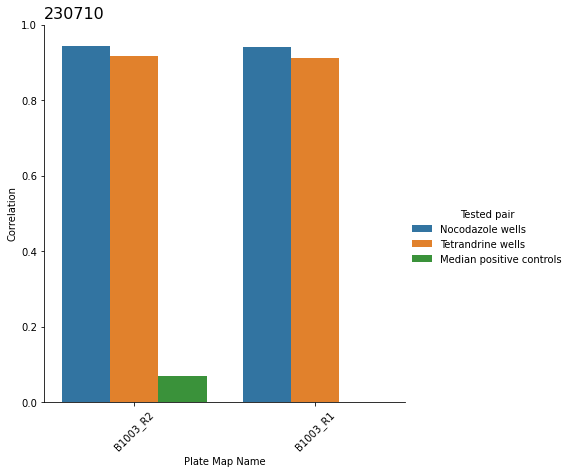

<Figure size 1008x504 with 0 Axes>

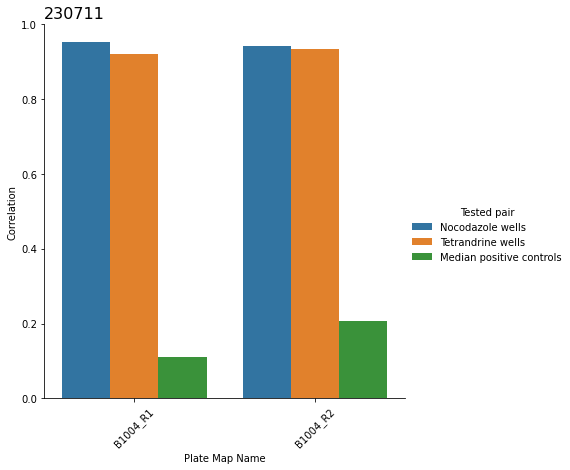

<Figure size 1008x504 with 0 Axes>

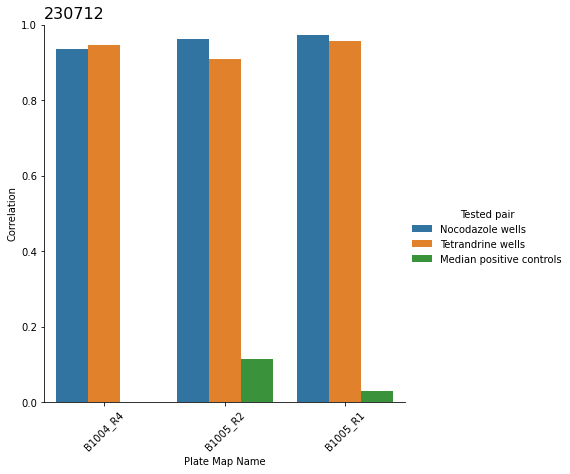

<Figure size 1008x504 with 0 Axes>

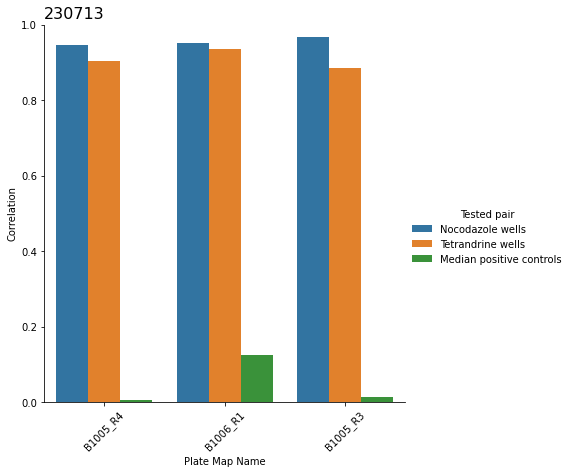

<Figure size 1008x504 with 0 Axes>

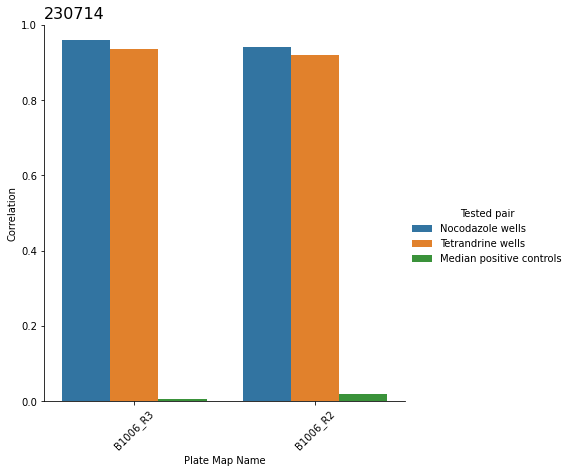

<Figure size 1008x504 with 0 Axes>

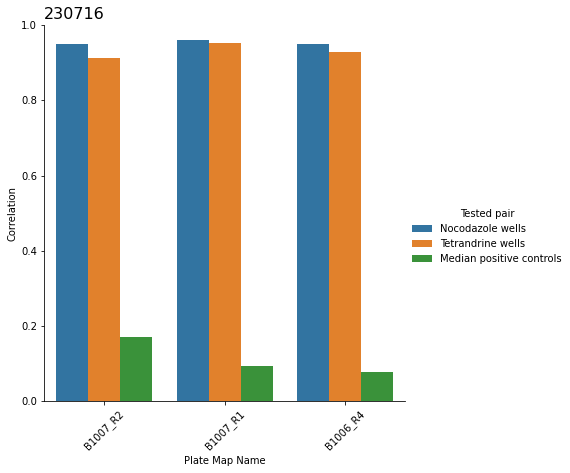

<Figure size 1008x504 with 0 Axes>

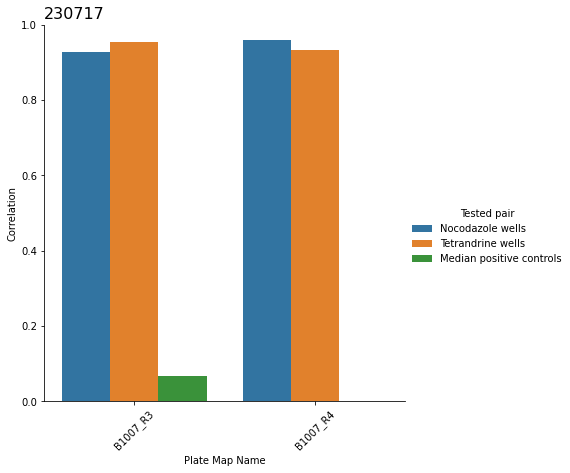

<Figure size 1008x504 with 0 Axes>

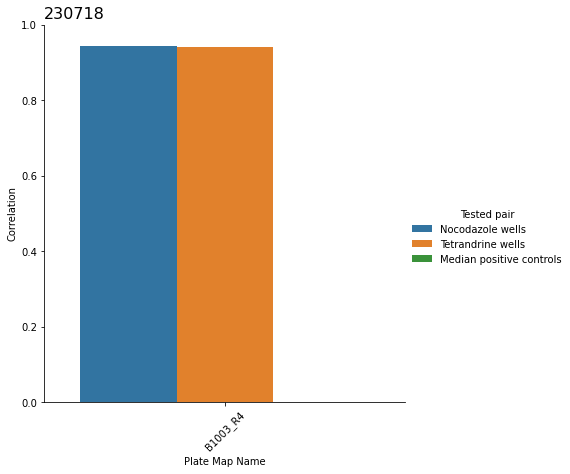

<Figure size 1008x504 with 0 Axes>

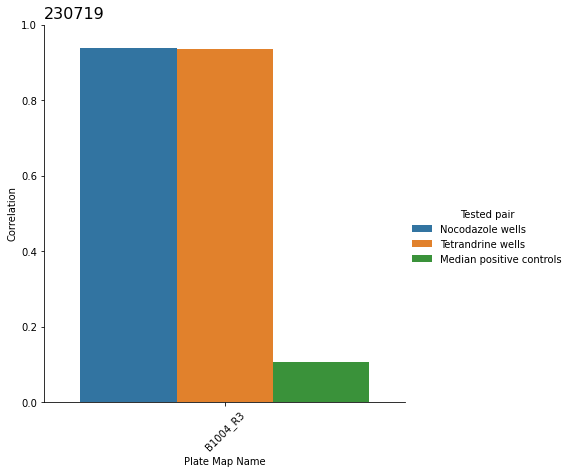

<Figure size 1008x504 with 0 Axes>

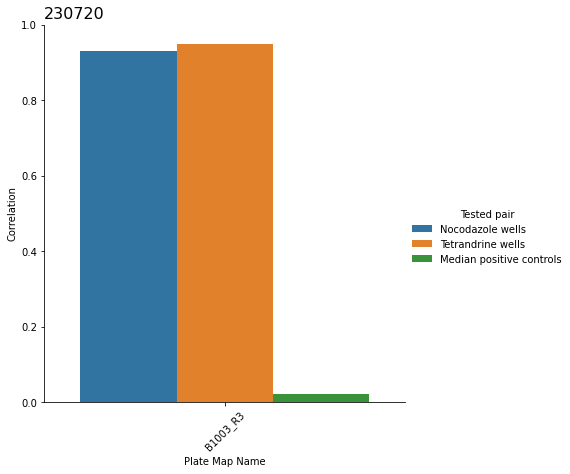

In [14]:
intra_plate_qc(quality_control_1_melt, 'IMTM', figure_path)

Error: directory cannot be created


<Figure size 1008x504 with 0 Axes>

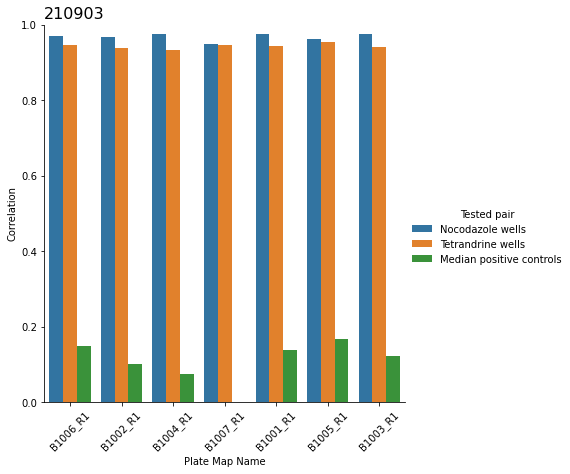

<Figure size 1008x504 with 0 Axes>

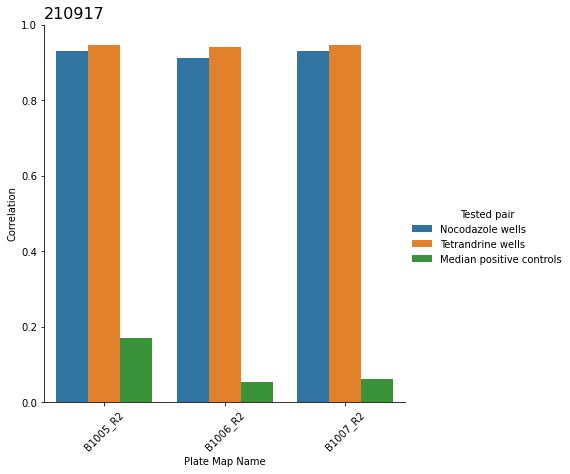

<Figure size 1008x504 with 0 Axes>

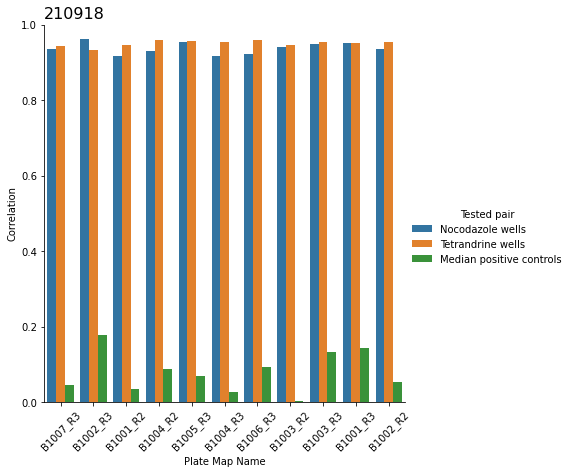

<Figure size 1008x504 with 0 Axes>

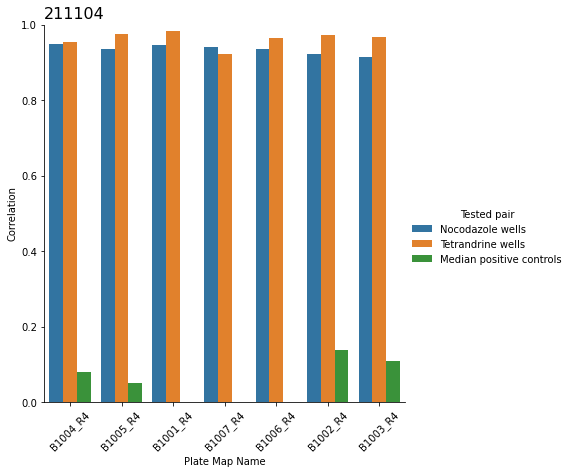

In [15]:
intra_plate_qc(quality_control_1_melt, 'FMP', figure_path)

Error: directory cannot be created


<Figure size 1008x504 with 0 Axes>

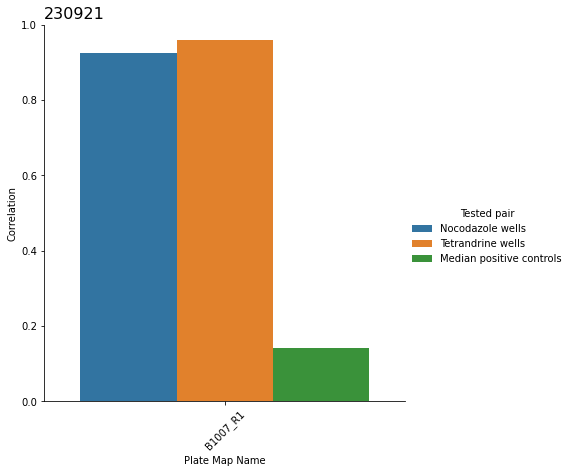

<Figure size 1008x504 with 0 Axes>

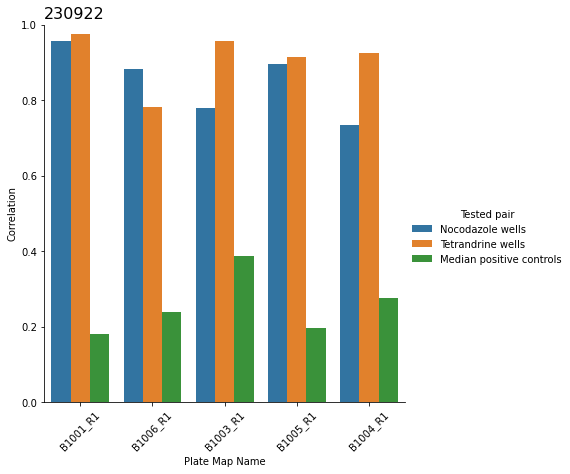

<Figure size 1008x504 with 0 Axes>

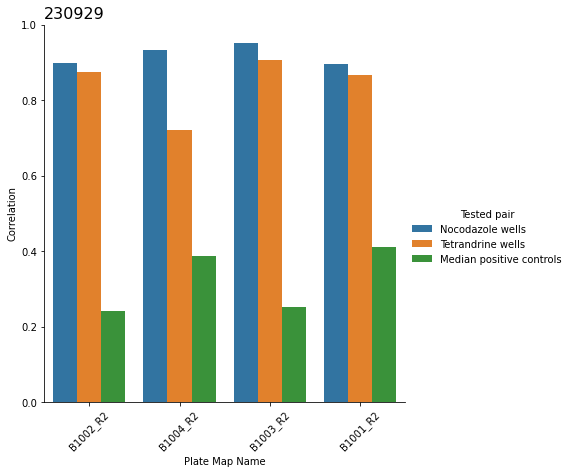

<Figure size 1008x504 with 0 Axes>

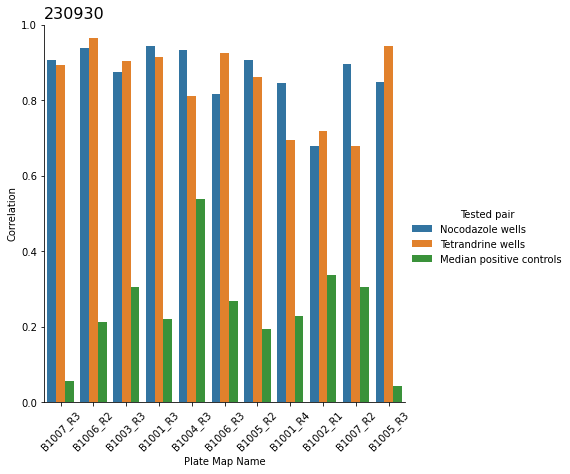

<Figure size 1008x504 with 0 Axes>

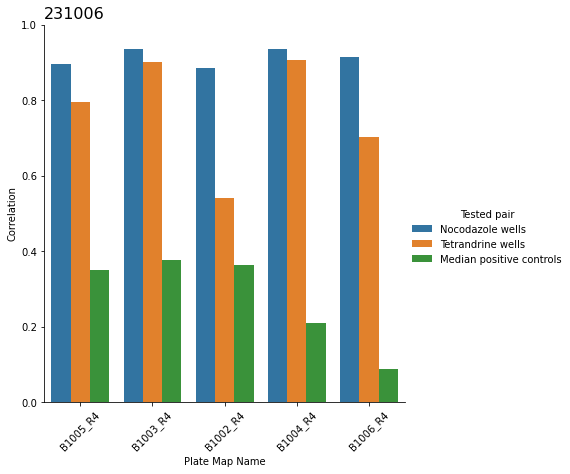

<Figure size 1008x504 with 0 Axes>

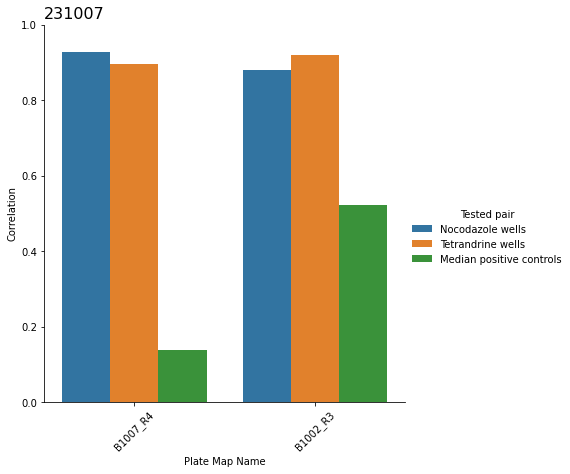

In [16]:
intra_plate_qc(quality_control_1_melt, 'USC', figure_path)

Error: directory cannot be created


<Figure size 1008x504 with 0 Axes>

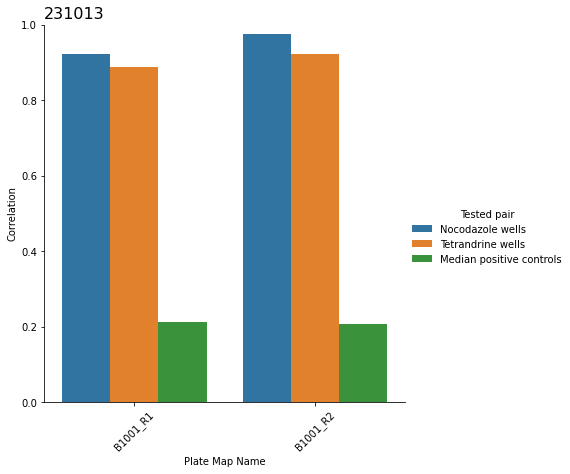

<Figure size 1008x504 with 0 Axes>

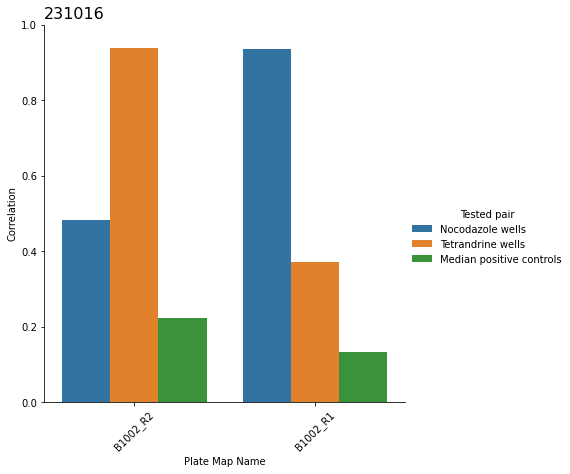

<Figure size 1008x504 with 0 Axes>

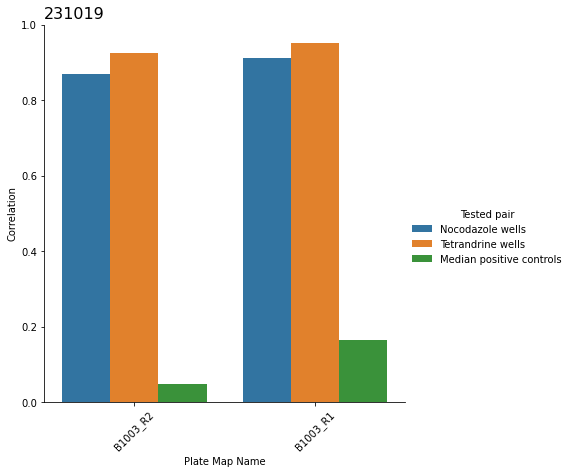

<Figure size 1008x504 with 0 Axes>

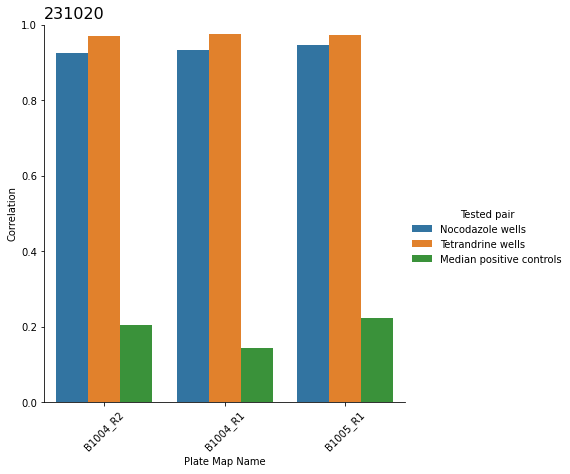

<Figure size 1008x504 with 0 Axes>

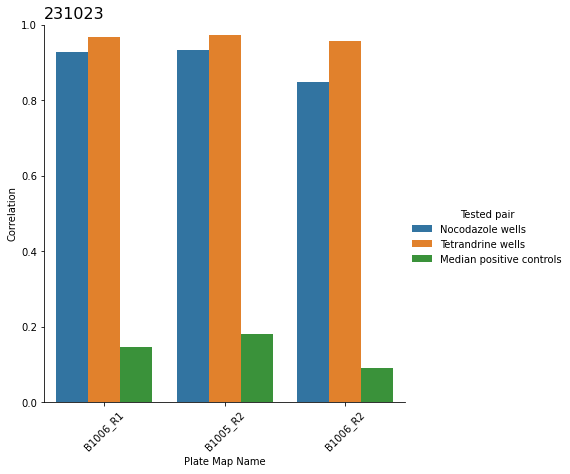

<Figure size 1008x504 with 0 Axes>

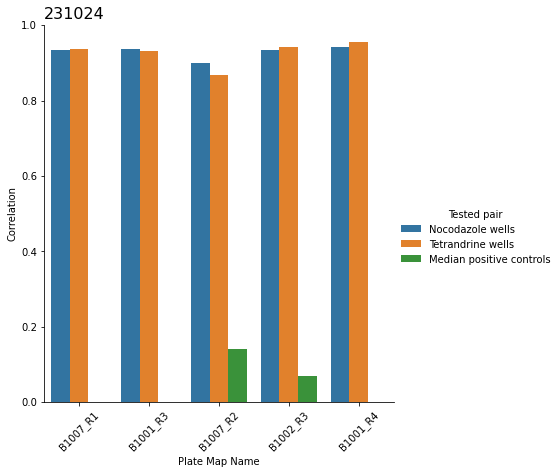

<Figure size 1008x504 with 0 Axes>

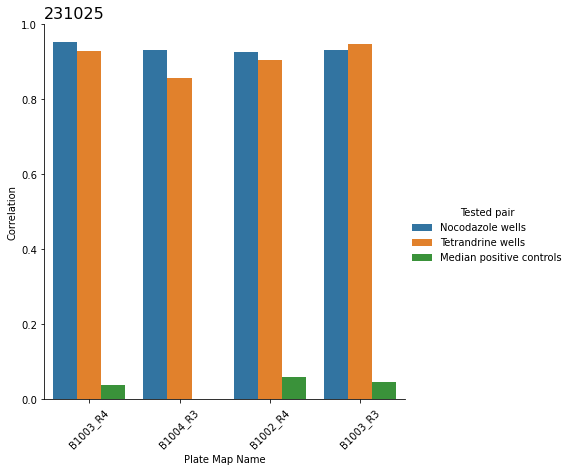

<Figure size 1008x504 with 0 Axes>

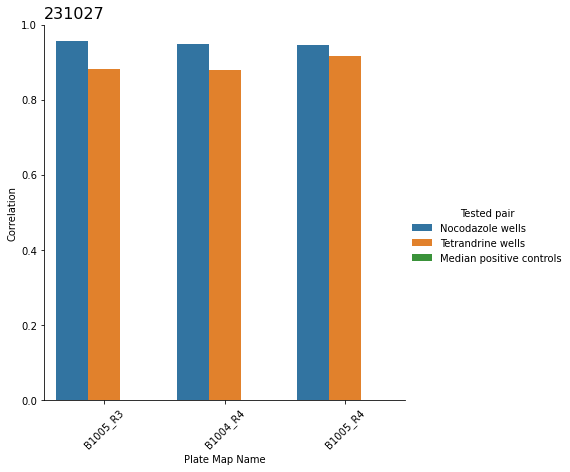

<Figure size 1008x504 with 0 Axes>

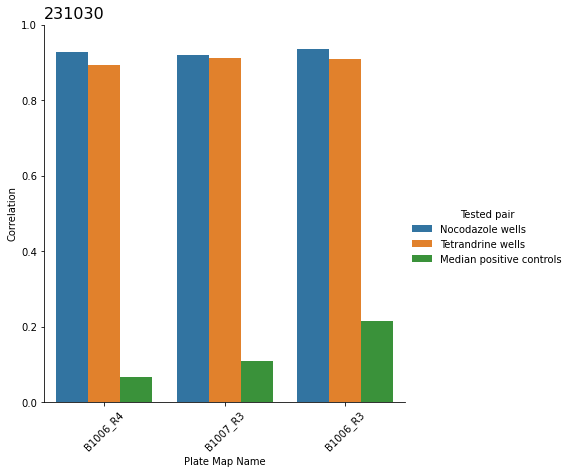

<Figure size 1008x504 with 0 Axes>

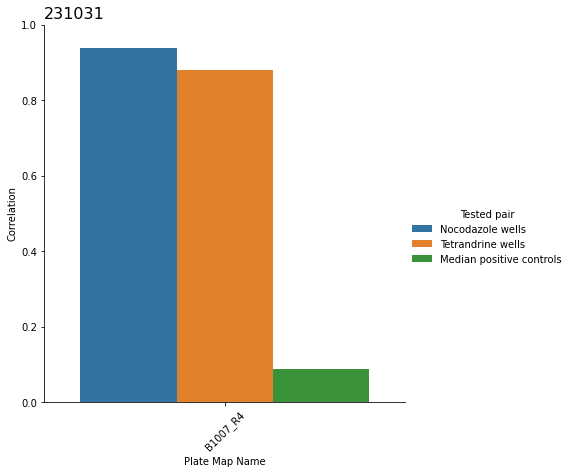

In [17]:
intra_plate_qc(quality_control_1_melt, 'MEDINA', figure_path)